In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
class linear_module_up(layers.Layer):
    
    def __init__(self):
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x):
        
        L = tf.concat([[[1., self.w]], [[0., 1.]]], 0)
        
        return tf.linalg.matvec(L,x)

class linear_module_low(layers.Layer):
    
    def __init__(self):
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x):
        
        L = tf.concat([[[1., 0.]], [[self.w, 1.]]], 0)
        
        return tf.linalg.matvec(L,x)


class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        L = tf.concat([[x[0] + self.w*tf.math.tanh(x[1])], [x[1]]], 0)
        return L

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        
        self.w = self.add_weight(
        name='w',
        shape=(),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        L = tf.concat([[x[0]], [x[1] + self.w*tf.math.tanh(x[0])]], 0)
        return L


In [18]:
class SympNet(keras.Model):
    
    def __init__(self, num_classes = 10):
    
        super().__init__()
        
        self.l1 = linear_module_up()
        self.l2 = linear_module_low()
        
        self.a1 = activation_module_up()
        
        self.l3 = linear_module_up()
        self.l4 = linear_module_low()
        
        self.a2 = activation_module_low()
        
        self.l5 = linear_module_up()
        self.l6 = linear_module_low()
        
        self.a3 = activation_module_up()

    
    def call(self, input_tensor):
        
        boom = self.l1(input_tensor)
        boom1 = self.l2(boom)
        
        boom2 = self.a1(boom1)
        
        boom3 = self.l1(boom2)
        boom4 = self.l2(boom3)
        
        boom5 = self.a2(boom4)
        
        boom6 = self.l1(boom5)
        boom7 = self.l2(boom6)
        
        boom8 = self.a2(boom7)

        return boom8

In [19]:
def leapfrog(q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] - 0.5*Δt*mt.sin(q[-1]))
        q.append(q[-1] + Δt*p̄[-1])
        p.append(p̄[-1] - 0.5*Δt*mt.sin(q[-1]))
    
    X = []
    for i,j in zip(p,q):
        X.append([i,j])
    return X[0:len(X)-1], X[1:]

def plot_true_tr(leapfrog, q0, p0, Δt, N):
    X = leapfrog(q0, p0, Δt, N)[0]
    q = []
    p = []
    for i in range(len(X)):
        q.append(X[i][0])
        p.append(X[i][1])
    plt.scatter(p, q)

In [20]:
model = SympNet()

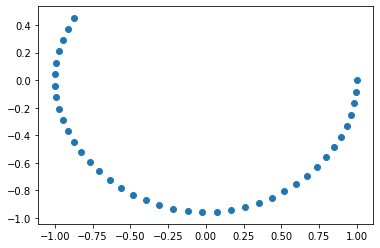

In [21]:
q0 = 1.
p0 = 0.
Δt = 0.1
N = 40

X = leapfrog(q0, p0, Δt, N)
plot_true_tr(leapfrog, q0, p0, Δt, N)

In [35]:
model(np.array(X[0])[0])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.03965561,  0.99805266], dtype=float32)>

In [17]:
model.compile(
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

start_time = time.time()

model.fit(np.array(X[0]), np.array(X[1]), batch_size=2, epochs=400, verbose=0);
#model.evaluate(x, y, batch_size=1, verbose=2)

print("running time : %s seconds" % (time.time() - start_time))

running time : 20.21994185447693 seconds


In [53]:
model.compile(
    #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

x = np.array([[[1., 1.]], [[1., 1.]], [[1., 1.]], [[1., 1.]]])     #, [1.,1.], [1.,1.]])

model.fit(x, x, batch_size=3, epochs=400, verbose=0);

InvalidArgumentError:  Incompatible shapes: [3,1,2] vs. [2,1,2]
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-53-13e6e972014b>:10) ]] [Op:__inference_train_function_66785]

Errors may have originated from an input operation.
Input Source operations connected to node mean_squared_error/SquaredDifference:
 symp_net_2/activation_module_low_2/concat_1 (defined at <ipython-input-4-fbfbd182d322>:69)

Function call stack:
train_function


In [51]:
x.shape

(2, 1, 2)

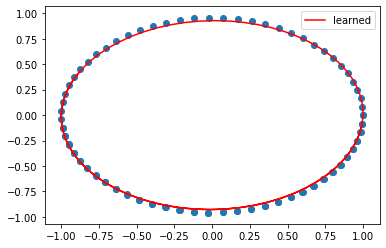

In [290]:
N_test = 100

p = [model(X[0][0])[0]]
q = [model(X[0][0])[1]]

run = [model(X[0][0])]
for i in range(N_test):
    run.append(model(run[-1]))
    p.append(run[-1][0])
    q.append(run[-1][1])

plot_true_tr(leapfrog, q0, p0, Δt, N_test)
plt.plot(q, p, color = "r", label = "learned")
plt.legend()
plt.show()